In [1]:
# Execute this cell to get the notebook style adjusted:
# from IPython.core.display import HTML
# HTML(open('nb_style.css', "r").read())

# Introduction

This exercise provides an example how the range-compression (range-focusing) of a radar system works. Another keyword for the method is ”matched pulse” filtering. (Frequency- step radars and frequency-modulated continous wave (FMCW) radars use a different approach.)

In [2]:
%matplotlib inline

In [3]:
# Import necessary package here.
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq

# Configure plot universal property
plt.rcParams['figure.figsize'] = (12,10)
plt.rcParams['font.size'] = 16

## 1.  [Chirped Pulse](https://en.wikipedia.org/wiki/Chirp)

Plot real and imaginary components of a chirped puls $s(t)$ with the form:

$$
s(t) =\begin{cases}
\begin{aligned}
&\exp{(it\cdot[\omega_0+\pi\beta_c t])} \ \ &|t| < \frac{\tau_p}{2}  \\
&0 & else
\end{aligned}
\end{cases}
$$

The pulse envelope is rectangular, which is also called **box-car**. 

Here $\omega_0=2\pi f_0$ is the central freuency $[s^{-1}]$, $\tau_p$ is the pulse length $[s]$ and $\beta_c$ is the requency change rate $[Hz/s]$. The bandwidth of the pulse is given by $f_{bw} = \beta_c\cdot \tau_p [Hz]$.

<div class="alert alert-info">
Task: Plot the the chirped pulse in time and frequency domain
</div>

In [4]:
def chirped_pulse(t, omega, beta, tau):
    
    x = (omega + np.pi*beta*t)*t
    s = np.exp(1j * x[:, np.newaxis])
    s[np.where(np.abs(t) >= tau/2)] = 0
    
    return s

In [5]:
dt = 3e-10
t0 = -1e-6
t1 = 1e-6
t = np.arange(t0, t1, dt)

freq = 20e6 # [Hz]
bw = 20e6 # [Hz]
tau = 1.5e-6 # [sec]

omega = 2*np.pi*freq
beta = bw / tau

# print('Central Angular Frequency is :{} Hz'.format(omega))
# print('Pulse Length is : {} s'.format(tau))
# print('Frequency change rate is: {} Hz/s'.format(beta))
# print('-'*60)
# print('Bandwidth is {} MHz'.format(beta*tau/1e6))

In [6]:
signal = chirped_pulse(t, omega, beta, tau)
signal_f = fft(signal[np.where(signal!=0)])
freq = fftfreq(signal_f.size, d = dt)

f0 = 0
f1 = 40e6
f0_phi = -20e6

f = np.where((freq>f0)&(freq<f1))
f_phi = np.where((freq>f0_phi)&(freq<f1))

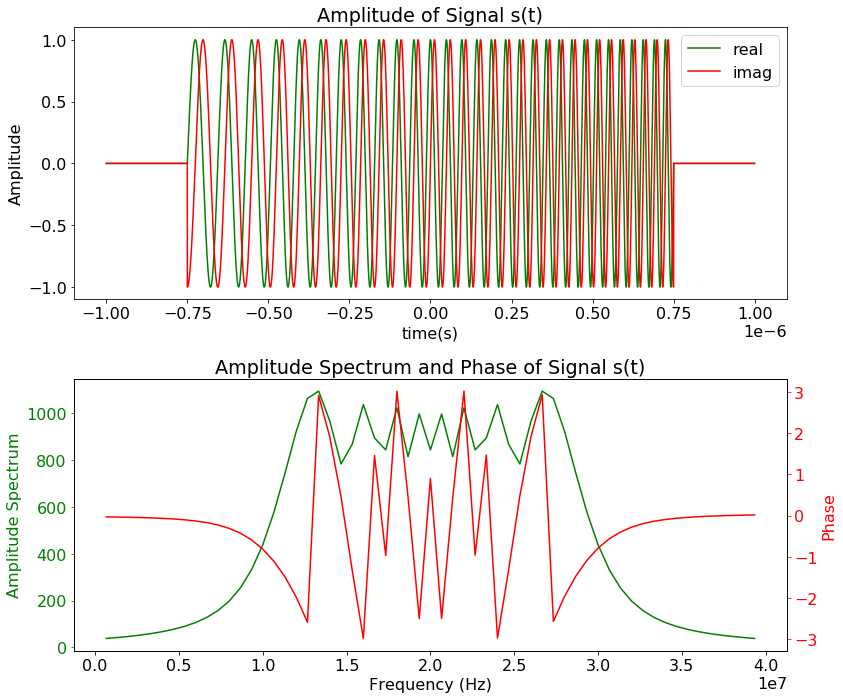

In [7]:
fig = plt.figure()

# Plot signal in time domain
ax1 = fig.add_subplot(211)
ax1.plot(t, np.real(signal), 'g', label='real')
ax1.plot(t, np.imag(signal), 'r', label='imag')
ax1.legend(loc='upper right')
ax1.set_title('Amplitude of Signal s(t)')
ax1.set_xlabel('time(s)')
ax1.set_ylabel('Amplitude')
ax1.ticklabel_format(axis='x', style='sci', scilimits=(-3,4))

# Plot signal in frequency domain
ax2 = fig.add_subplot(212)
# ax2 = ax1.twinx()
ax2.plot(freq[f], np.abs(signal_f)[f], 'g')
ax2.set_title('Amplitude Spectrum and Phase of Signal s(t)')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude Spectrum', color='g')
ax2.tick_params('y', colors='g')

ax3 = ax2.twinx()
ax3.plot(freq[f], np.angle(signal_f)[f], 'r', label='imag')
ax3.set_ylabel('Phase', color='r')
ax3.tick_params('y', colors='r')
# ax3.set_ylim(0, 60)
ax2.ticklabel_format(axis='x', style='sci', scilimits=(-3,4))

# Layout
plt.tight_layout()

## 2.  Pulse Compression

Compress the pulse in time/frequency domain by a convolution with the filter function $h(t)$ and plot it. 

- Time Domain

In principle you calculate the autocorrelation function $g_1(\tau)$ of the pulse with itself:

$$
g_1(\tau) = \int_{-\infty}^{+\infty} s^*(t)s(t+\tau)dt = \int s(t')h(\tau-t')dt' = (s\ast h)(\tau)
$$

where $t'=t+\tau$.

- Frequency Domain

As the convolution is very computationally intense compress the pulse in frequency domain:

$$
g_1(\tau) = \mathcal{F}^{-1}\{ \mathcal{F} ((s*h)(\tau) )\} = \mathcal{F}^{-1}\{\tilde{s}(\omega)\cdot\tilde{h}(\omega) \}
$$

### 2-1. Matched Filter

The matched filter function is defined as $h(t)=s^*(-t)$.

$$
h(t)=s^*(-t) = \begin{cases}
\begin{aligned}
&\exp{(it\cdot[\omega_0 - \pi\beta_c t])} \ \ &|t| < \frac{\tau_p}{2}  \\
&0 & else
\end{aligned}
\end{cases}
$$

<div class="alert alert-info">
Task: Plot the matched filter $h(t)$ in both domain.
</div>

In [8]:
def matched_filter(t, omega, beta, tau):
    
    x = (omega - np.pi*beta*t)*t
    s = np.exp(1j * x[:, np.newaxis])
    s[np.where(np.abs(t) >= tau/2)] = 0
    
    return s

In [9]:
m_filter = matched_filter(t, omega, beta, tau)
m_filter_f = fft(m_filter[np.where(signal!=0)])
freq = fftfreq(m_filter_f.size, d = dt)

f0 = 0
f1 = 40e6
f0_phi = -20e6

f = np.where((freq>f0)&(freq<f1))
f_phi = np.where((freq>f0_phi)&(freq<f1))

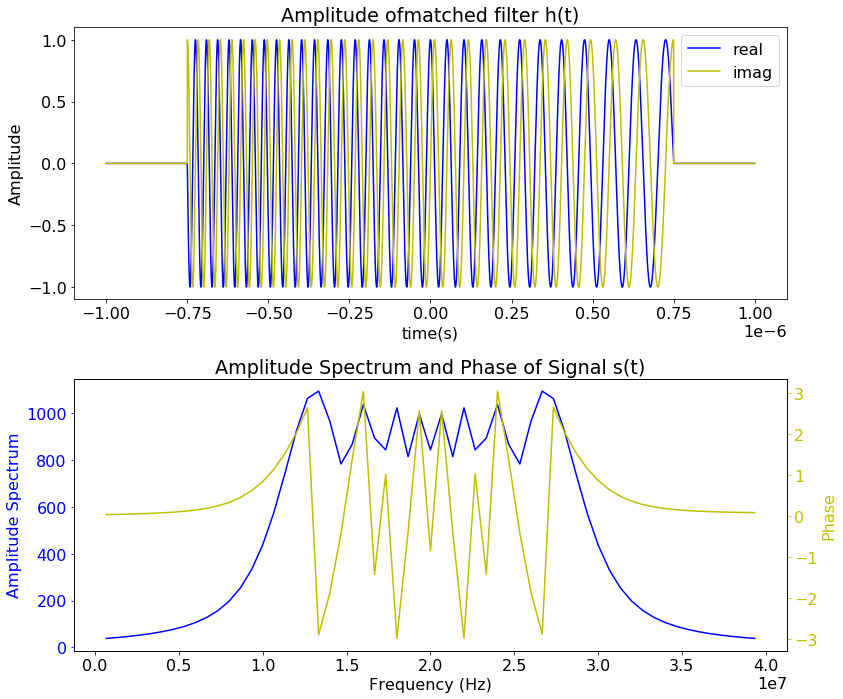

In [10]:
fig = plt.figure()

# Plot signal in time domain
ax1 = fig.add_subplot(211)
ax1.plot(t, np.real(m_filter), 'b', label='real')
ax1.plot(t, np.imag(m_filter), 'y', label='imag')
ax1.legend(loc='upper right')
ax1.set_title('Amplitude ofmatched filter h(t)')
ax1.set_xlabel('time(s)')
ax1.set_ylabel('Amplitude')
ax1.ticklabel_format(axis='x', style='sci', scilimits=(-3,4))

# Plot signal in frequency domain
ax2 = fig.add_subplot(212)
# ax2 = ax1.twinx()
ax2.plot(freq[f], np.abs(m_filter_f)[f], 'b')
ax2.set_title('Amplitude Spectrum and Phase of Signal s(t)')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude Spectrum', color='b')
ax2.tick_params('y', colors='b')

ax3 = ax2.twinx()
ax3.plot(freq[f], np.angle(m_filter_f)[f], 'y', label='imag')
ax3.set_ylabel('Phase', color='y')
ax3.tick_params('y', colors='y')
# ax3.set_ylim(0, 60)
ax2.ticklabel_format(axis='x', style='sci', scilimits=(-3,4))

# Layout
plt.tight_layout()

<div class="alert alert-info">
Task: Plot the compressed signal in both domain.
</div>

In [11]:
compressed = np.convolve(signal.flatten(), m_filter.flatten(), 'same')
compressed_f = signal_f * m_filter_f

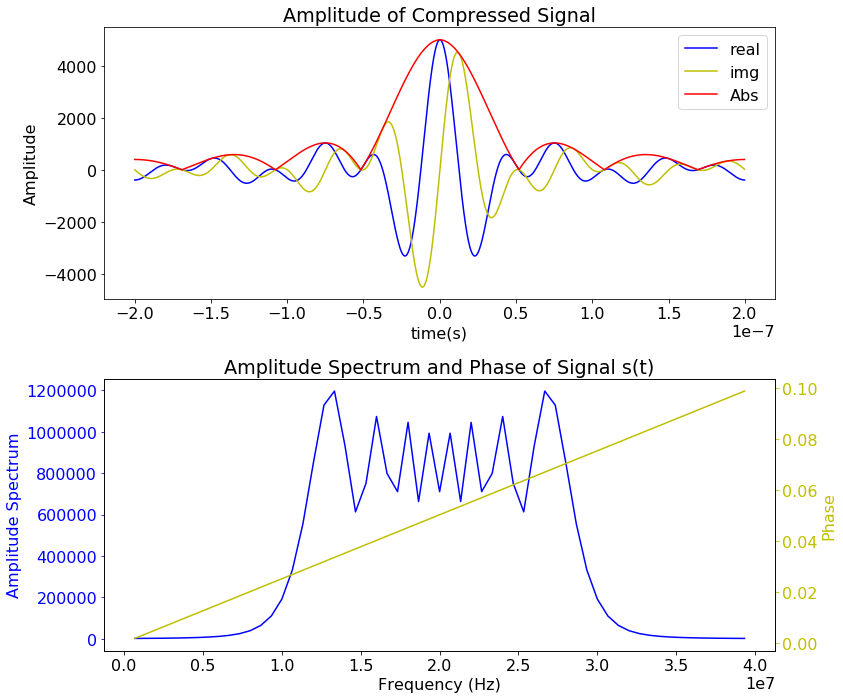

In [12]:
t_interval = [-0.2e-6, 0.2e-6]
st = np.where(t_interval[0] < t)[0].min()
sp = np.where(t_interval[1] < t)[0].min()

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(t[st:sp], np.real(compressed)[st:sp], 'b', label='real')
ax.plot(t[st:sp], np.imag(compressed)[st:sp], 'y', label='img')
ax.plot(t[st:sp], np.abs(compressed)[st:sp], 'r', label='Abs')
# ax.ylim([-2000, 4000])
ax.set_xlabel('time(s)')
ax.set_ylabel('Amplitude')
ax.legend()
ax.set_title('Amplitude of Compressed Signal')
ax.ticklabel_format(axis='x', style='sci', scilimits=(-3, -4))

# Plot signal in frequency domain
ax2 = fig.add_subplot(212)
# ax2 = ax1.twinx()
ax2.plot(freq[f], np.abs(compressed_f)[f], 'b')
ax2.set_title('Amplitude Spectrum and Phase of Signal s(t)')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude Spectrum', color='b')
ax2.tick_params('y', colors='b')

ax3 = ax2.twinx()
ax3.plot(freq[f], np.angle(compressed_f)[f], 'y', label='imag')
ax3.set_ylabel('Phase', color='y')
ax3.tick_params('y', colors='y')
# ax3.set_ylim(0, 60)
ax2.ticklabel_format(axis='x', style='sci', scilimits=(-3,4))

# Layout
plt.tight_layout()

### 2-2. [Hamming Window](https://en.wikipedia.org/wiki/Window_function#Hann_and_Hamming_windows)

The hamming window is used to reduce side lobes.
$$
w(t) = -(\alpha -1)\cdot \cos{(\frac{2\pi t}{\tau_p})} + \alpha
$$

<div class="alert alert-info">
Task: Use a hamming window ($\alpha = 0.54$) to weighten the sharp edges of the pulse in time domain and compare the the compressed pulse (and the side-lobes) in <a href="#2-1.-Matched-Filter" class="alert-link">Section 2.1</a>
</div>

In [13]:
def hamming_window(t, alpha, tau):
    w = -(alpha - 1) * np.cos(2*np.pi*t/tau) + alpha
    return w

In [14]:
alp = 0.54

hw = hamming_window(t, alp, tau)
hammed = np.convolve(signal.flatten(), hw.flatten(), 'same')

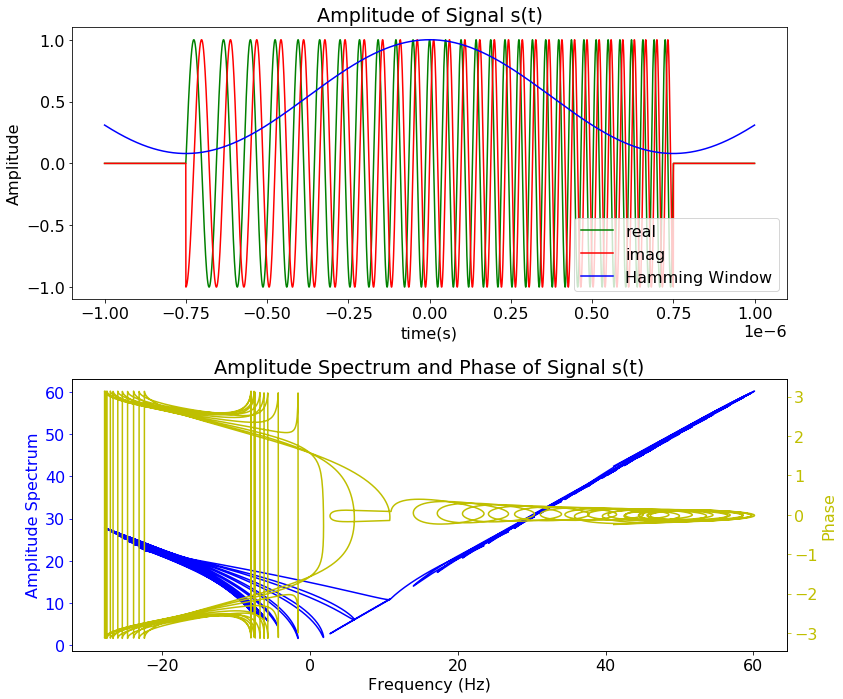

In [17]:
fig = plt.figure()

# Plot signal in time domain
ax1 = fig.add_subplot(211)
ax1.plot(t, np.real(signal), 'g', label='real')
ax1.plot(t, np.imag(signal), 'r', label='imag')
ax1.plot(t, hw, 'b', label='Hamming Window')
ax1.legend(loc='lower right')
ax1.set_title('Amplitude of Signal s(t)')
ax1.set_xlabel('time(s)')
ax1.set_ylabel('Amplitude')
ax1.ticklabel_format(axis='x', style='sci', scilimits=(-3,4))

# Plot signal in frequency domain
ax2 = fig.add_subplot(212)
# ax2 = ax1.twinx()
ax2.plot(hammed, np.abs(hammed), 'b')
ax2.set_title('Amplitude Spectrum and Phase of Signal s(t)')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude Spectrum', color='b')
ax2.tick_params('y', colors='b')

ax3 = ax2.twinx()
ax3.plot(hammed, np.angle(hammed), 'y', label='imag')
ax3.set_ylabel('Phase', color='y')
ax3.tick_params('y', colors='y')
# ax3.set_ylim(0, 60)
ax2.ticklabel_format(axis='x', style='sci', scilimits=(-3,4))

# Layout
plt.tight_layout()